In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv("tud-alpha-energy.csv")
# df["datetime"] = pd.to_datetime(df["time"])
# df["power"] = (df["taurus.alpha.energy"].diff() / df["datetime"].diff().dt.total_seconds()) * 3600 * 1000
#
# df.plot(x="datetime", y="power", kind="scatter", figsize=(20, 10), marker=".")

In [3]:
df = pd.read_csv("tud-alpha-power.csv")
df["time"] = pd.to_datetime(df["time"])
core_phase_start = pd.to_datetime("2021-05-27T16:32:40.767+02:00")
core_phase_end = pd.to_datetime("2021-05-27T16:39:33.109+02:00")

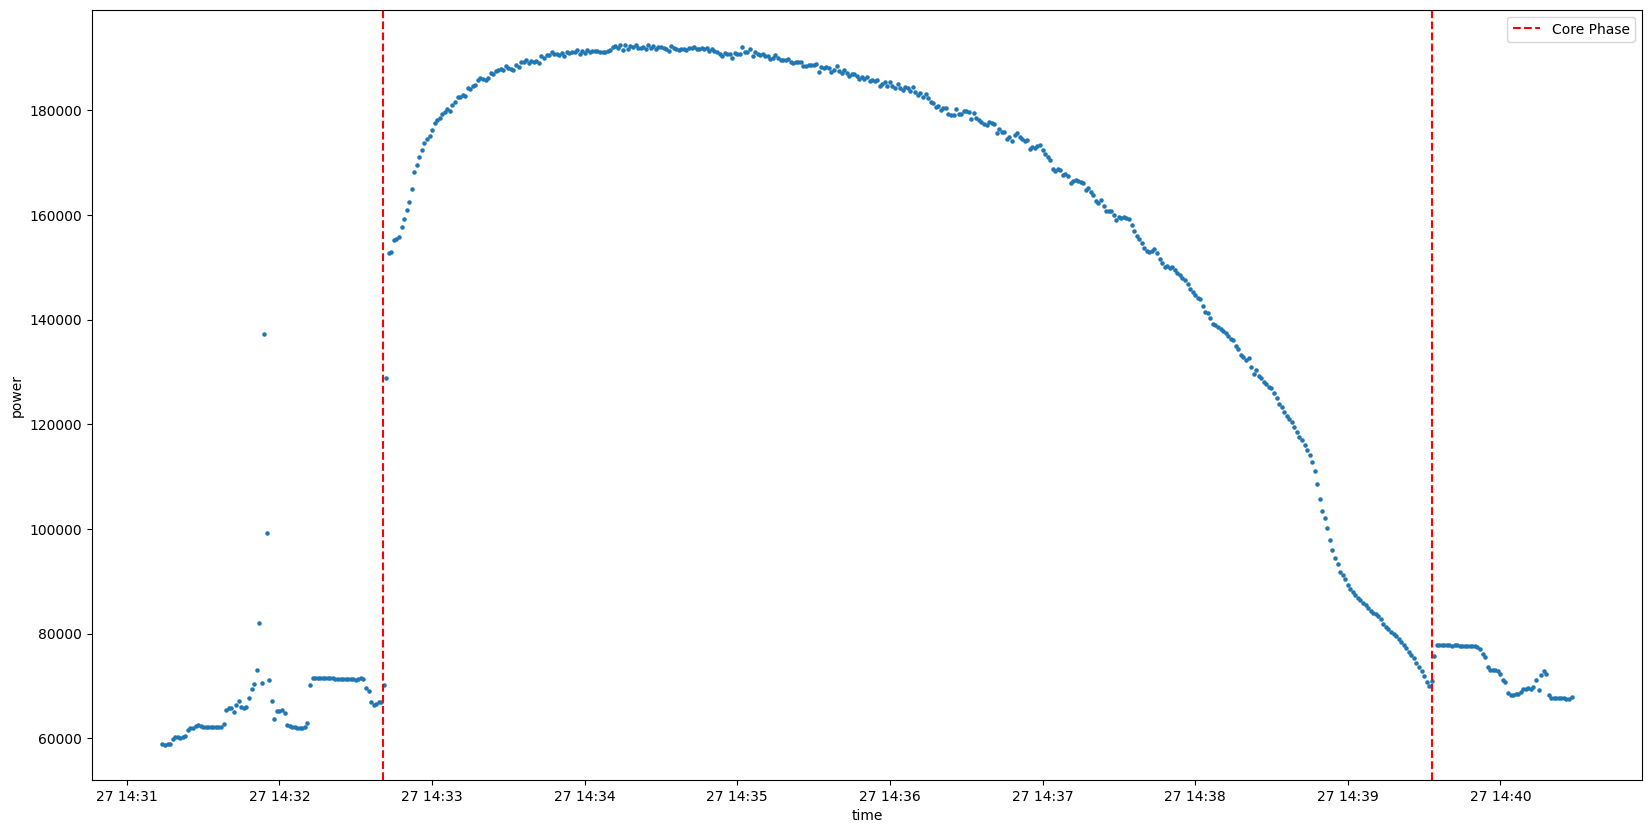

In [4]:
ax = df.plot(x="time", y="power", kind="scatter", figsize=(20, 10), marker=".")
ax.axvline(core_phase_start, color='r', linestyle='--', label='Core Phase')
ax.axvline(core_phase_end, color='r', linestyle='--')
ax.legend()

Max error 5.16%, mean error 1.84%


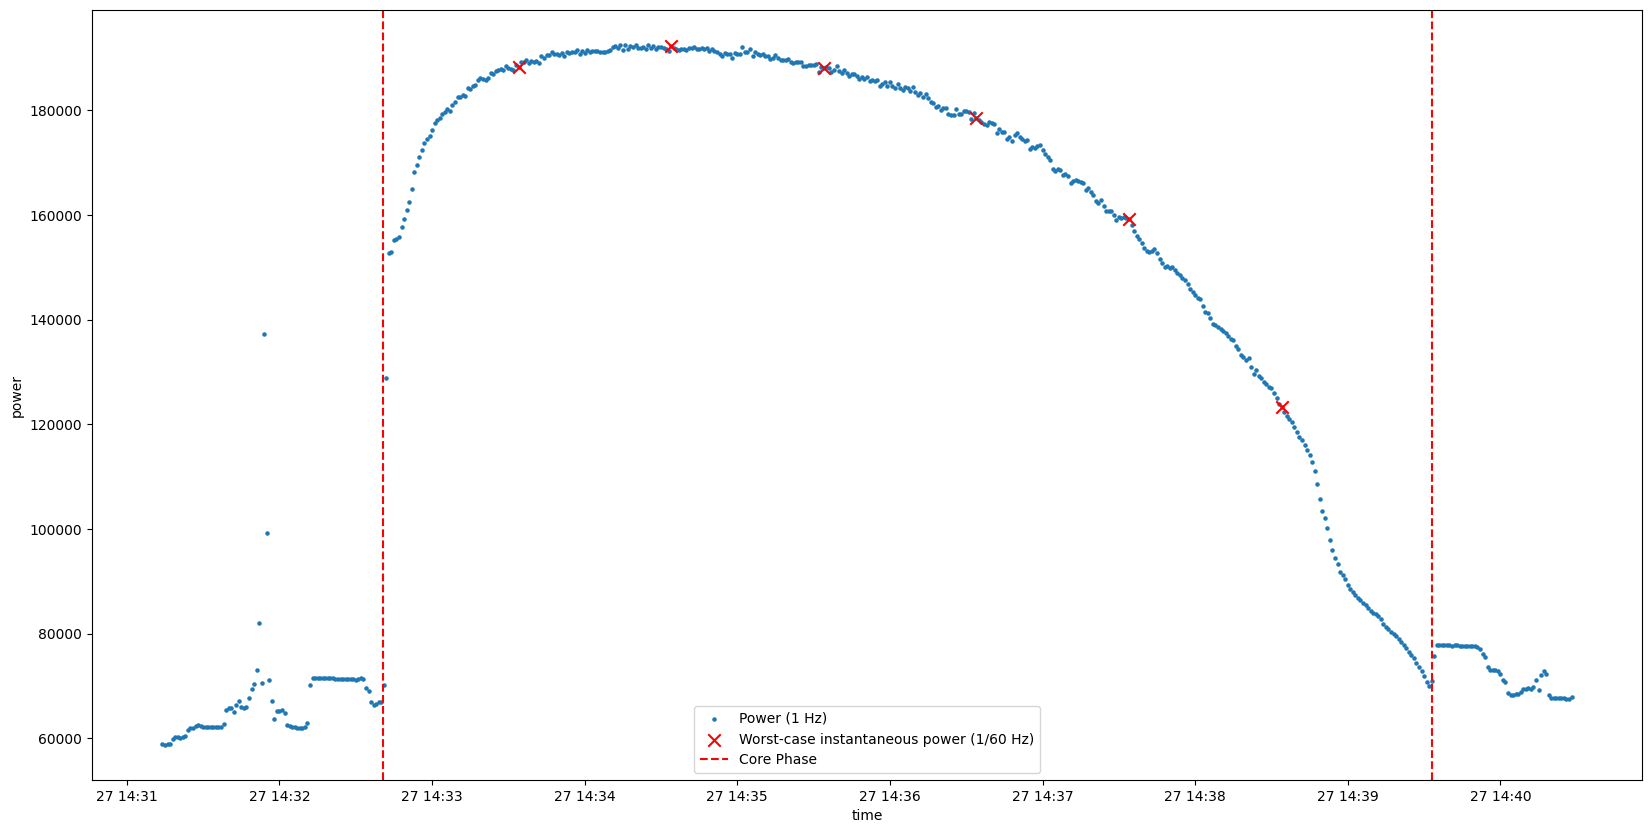

In [39]:
df_core = df[(df["time"] >= core_phase_start) & (df["time"] < core_phase_end)]
true_power = df_core.power.mean()
max_error = 0
errors = []
for shift in range(60):
        df_shifted = df_core[df_core["time"].dt.second == shift]
        shifted_power = df_shifted.power.mean()
        error = abs(true_power - shifted_power) / true_power
        errors.append(error)
        if error > max_error:
            max_error = error
            df_worst = df_shifted

print(f"Max error {max_error:.2%}, mean error {sum(errors) / len(errors):.2%}")

ax = df.plot(x="time", y="power", kind="scatter", figsize=(20, 10), marker=".", label="Power (1 Hz)")
df_worst.plot(x="time", y="power", kind="scatter", marker="x", s=80, ax=ax, color="red", label="Worst-case instantaneous power (1/60 Hz)")
ax.axvline(core_phase_start, color='r', linestyle='--', label='Core Phase')
ax.axvline(core_phase_end, color='r', linestyle='--')
ax.legend()

0     2021-05-27 14:31:14+00:00
1     2021-05-27 14:31:15+00:00
2     2021-05-27 14:31:16+00:00
3     2021-05-27 14:31:17+00:00
4     2021-05-27 14:31:18+00:00
                 ...           
550   2021-05-27 14:40:24+00:00
551   2021-05-27 14:40:25+00:00
552   2021-05-27 14:40:26+00:00
553   2021-05-27 14:40:27+00:00
554   2021-05-27 14:40:28+00:00
Name: time, Length: 555, dtype: datetime64[ns, UTC]